# 0. 사용할 패키지 불러오기

In [13]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 데이터 불러오기

In [14]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 120, 320, 1))
y_train = np.empty((0, 4))

training_data = glob.glob('./training_data/*.npz')

for single_npz in training_data:
    with np.load(single_npz) as data:
        x = data['train']
        y = data['train_labels']
    x = np.reshape(x, (-1, 120, 320, 1))
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:-1]
y_test = y_test[:,:-1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(22017, 120, 320, 1) (22017, 3)
(9436, 120, 320, 1) (9436, 3)


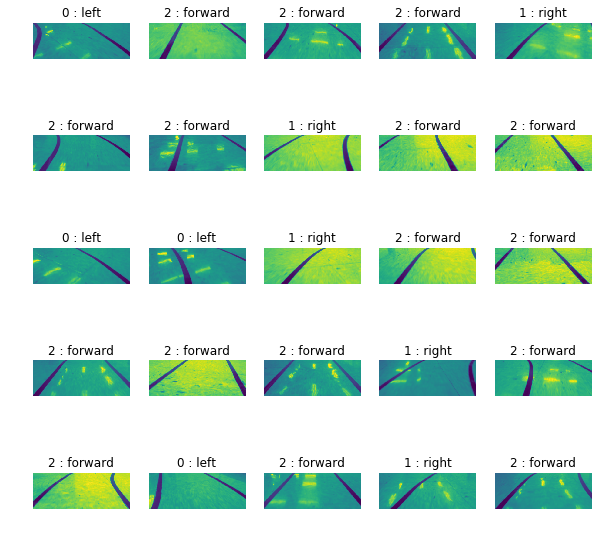

In [15]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(120, 320))
    
    label = np.argmax(y_train[i])
                      
    if label == 0 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 2:
        direction = 'forward'
    elif label == 3:
        direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [21]:
# image size = 96 x 96
def VGG_net():
    #with K.tf.device(gpu_usage):
    # model setting
    H = 120
    W = 320
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.5
    keep_prob_dense = 0.5

    chanDim = -1
    classes = 3

    model = Sequential()

    # CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(keep_prob_conv))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(keep_prob_conv))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(keep_prob_conv))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(keep_prob_conv))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Dropout(keep_prob_dense))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [22]:
model = VGG_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 120, 320, 32)      320       
_________________________________________________________________
activation_18 (Activation)   (None, 120, 320, 32)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 120, 320, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 106, 32)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 106, 32)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 40, 106, 64)       18496     
_________________________________________________________________
activation_19 (Activation)   (None, 40, 106, 64)       0         
__________

# 4. 모델 파라미터 셋팅

In [5]:
# 적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용
# aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
#     horizontal_flip=True, fill_mode="nearest")

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [8]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [23]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 64
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [ ]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1,
                 #callbacks=[early_stopping]
                )

Train on 17613 samples, validate on 4404 samples
Epoch 1/50
17613/17613 [==============================] - 30s 2ms/step - loss: 0.7950 - acc: 0.7495 - val_loss: 1.1090 - val_acc: 0.5929
Epoch 2/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.4947 - acc: 0.8359 - val_loss: 0.9972 - val_acc: 0.5845
Epoch 3/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.4235 - acc: 0.8508 - val_loss: 1.2225 - val_acc: 0.6074
Epoch 4/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.3857 - acc: 0.8584 - val_loss: 0.8180 - val_acc: 0.6437
Epoch 5/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.3601 - acc: 0.8638 - val_loss: 0.6124 - val_acc: 0.7352
Epoch 6/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.3453 - acc: 0.8708 - val_loss: 0.6701 - val_acc: 0.6996
Epoch 7/50
17613/17613 [==============================] - 28s 2ms/step - loss: 0.3207 - acc: 0.8731 - val_loss: 1.4730 - val_acc:

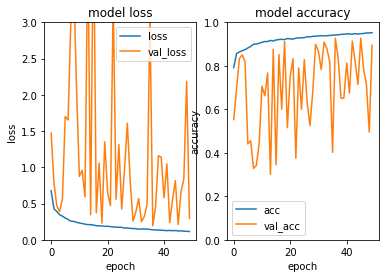

In [16]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,3))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0, 1))

plt.show();

# 6. 모델 결과 확인

In [17]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

9436/9436 [==============================] - 5s 549us/step
## evaluation loss and_metrics ##
[0.2965201198195643, 0.8935989828218894]


In [18]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 0, Predict : 0
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 2, Predict : 2
True : 0, Predict : 0
True : 2, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 1
True : 0, Predict : 0


# 7. 최종 모델 훈련

In [ ]:
x_train = np.vstack((x_train, x_test))
y_train = np.vstack((y_train, y_test))

#hist = model.fit(x, y, epochs=EPOCHS, batch_size=BS, validation_split=split_ratio, shuffle=True)

# 8. 모델 저장

In [12]:
#model.save_model(path = './model_data/VGG_model.h5')

AttributeError: 'Sequential' object has no attribute 'save_model'